# Online News Popularity

Parth Girme, Eugene Olkhov, Matthew Shaw

## Business Context

* ### **Who: Mashable**
     * Global media platform specializing in tech, digital culture and entertainment content
     * 28M social media followers; 7.5M articles shared monthly
     
* ### **What: Business Question**
     * Can Mashable predict how popular a given article will be?
     
* ### **Why: Business Impact**
     * Optimize allocation of advertisements to viral articles
     * Dynamic advertising pricing based on predicted popularity

## Results

* Logistic regression gives us a decent prediction of the types of articles that are more likely to go viral. 
* Articles with less repetitive language and that are posted during the weekend are more likely to go viral. 
* Articles that are categorized as business, entertaintment, world, and lifestyle are less likely to go viral. 

## Application - Dynamic Marketing Pricing

*  Price of advertisements adjusted based on article's probability of going viral.
*  For example, if the cost of the advertisement is 100 dollars, and the probability of the particular article going viral is 0.75, then the adjusted price will be 75 dollars.
* Greater flexibility for advertisers can help Mashable build better relationships, increasing ad revenue over time.
 
## Data Collection and Cleaning

Data was acquired from the UCI Machine Learning Repository. 

* **Original Source:** K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal

The data consisted of information on 39,644 unique articles. Our target variable was number of shares, which was converted into a binary viral/not viral variable.

A few of the variables (different information about the articles) were removed for not logically being able to contribute to our goal of predicting virality. Some of these variables included:

* Information on whether or not the article was published on a weekend (this resulted in multicollinearity with the day an article was published).
* Text subjectivity information (this was difficult to interpret). 

Some of the variables that we kept included:                                    

* Article word count
* Number of images, videos, links in the article
* Article theme and topic
* Sentiment score (positive/negative valence)

|                       | Raw Data | Cleaned Data |
|-----------------------|----------|-------------:|
| Observations          |   39,644 |       39,644 |
| Variables             |       60 |           43 |
| Numeric Variables     |       45 |           29 |
| Categorical Variables |       14 |           13 |



In [1]:
## importing relevant packages
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
##NOTE: The code includes seaborn scatterplots, which require an updated version of seaborn. May not run.
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestRegressor



df = pd.read_csv('OnlineNewsPopularity.csv')
df_main = pd.read_csv('OnlineNewsPopularity.csv')
df.drop(['url', ' timedelta', ' kw_min_min', ' kw_max_min', ' kw_avg_min', ' kw_min_max',' kw_max_max',
         ' kw_avg_max',' kw_min_avg',' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
         ' self_reference_max_shares', ' self_reference_avg_sharess', ' is_weekend',
         ' global_subjectivity', ' title_subjectivity', ' abs_title_subjectivity'],
         axis = 1, inplace = True)
##-- We downloaded data from the UCI repository, unfortunately some of the variable descriptions were 
##-- not clear and hence we had to remove said variables from the beginning. Also created a main data file
##-------------------------------------------------------------------------------------------------------

## converting categorical variables to 'object' type & running a correlation
threshold = 7
nan = []
for i in df:
    if df[i].nunique() <= threshold:
        nan.append(i)
        df[nan] = df[nan].astype(object)

a = df.corr()
##-- We converted the categorical variables to object by setting a threshold on the number of unique
##-- observations. In this case we set the threshold to 7(we knew the least unique number of observation
##-- for continuous variables) and said all the variable with unique number of observations under 7 are
##-- categorical, which they are. 
##-------------------------------------------------------------------------------------------------------

## Further removing the variables based on correlation
df.drop([' n_non_stop_words', ' n_non_stop_unique_tokens', ' global_rate_positive_words'
             , ' global_rate_negative_words', ' rate_positive_words', ' rate_negative_words'
             , ' min_positive_polarity', ' max_positive_polarity', ' min_negative_polarity'
             , ' max_negative_polarity', ' avg_positive_polarity', ' avg_negative_polarity']
             , axis = 1, inplace = True)
##-- Further removed correlated variables to avoid multicollinearity  
##-------------------------------------------------------------------------------------------------------


In order to determine where to set the threshold which separates the number of shares into viral or non-viral, we created a cumulative frequency plot to see where the distance between total shares of each article starts to become farther apart. In the below plot, we see that the frequencies start to become more spread out a little after 1,000 shares. However, we decided to use 3,000 shares as our threshold as that is where the curve begins to level. Also, by using 3,000 as the threshold, we break viral / non-viral into a 20% / 80% split. 

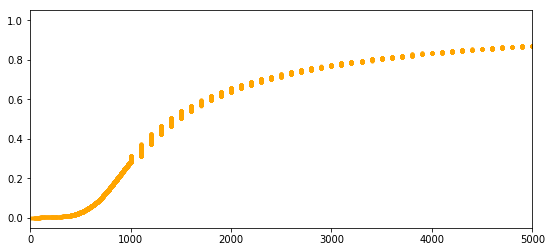

In [4]:

def cdf(x):
        x = np.sort(x)
        n = len(x)
        y = np.arange(1, n + 1, 1)/n
        return x, y 
    
x, y = cdf(df[' shares'])

f, ax = plt.subplots(figsize=(9,4))
ax.plot(x,y,'.', color = "orange", alpha = .3)
ax.set_xlim(0,5000)
f

In [5]:
## setting the threshold for the binary 'y' predictor variable & standardizing the data 
df['y'] = np.where((df[' shares'] >= 3000), 1, 0)
df.drop(' shares', axis = 1, inplace = True)
df.loc[:, df.dtypes == np.float64] = StandardScaler().fit_transform(df.loc[:, df.dtypes == np.float64])
##-- We also created the predictor 'y' variable based on the threshold we got from the propensity graph
##-- we saw earlier, and standardized the data for prediction purposes.

## Logistic Regression

*  Ease of interpretability for business purposes
*  Relative importance of variables on predicting popularity

Below is the logistic regression pipeline for developing our model. We implement splitting the data into training and testing sets by training the model on one set of the data, and then predicting on the testing set to check how generalizable the model is to unseen data. We then output the top 10 coefficients with the highest betas (in both positive and negative directions) to see which variables are most important in predicting if an article will go viral. 

In [8]:
# initiating Logistic Regression
log_reg = LogisticRegression(C = 5) 

# Separating dependent & independent variables
X = df.iloc[:,0:30]
y = df.iloc[:,30]
y = pd.Series(y)

# Splitting for test & train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)   
# fitting the regression on our training data 
log_reg.fit(X_train, y_train)
# predictions on our testing data
y_pred = log_reg.predict_proba(X_test)  

# Getting the top 10 coefficients
coef = pd.DataFrame(log_reg.coef_).T
coef = pd.concat([pd.DataFrame(X_test.columns),coef], axis = 1)
coef.columns = ['name', 'coef']
coef.nlargest(5,'coef')

,name,coef
2,n_unique_tokens,0.651865
21,weekday_is_sunday,0.256685
20,weekday_is_saturday,0.226049
22,LDA_00,0.171240
3,num_hrefs,0.124385


In [7]:
coef.nsmallest(5,'coef')

,name,coef
11,data_channel_is_bus,-0.844467
10,data_channel_is_entertainment,-0.739846
14,data_channel_is_world,-0.599321
9,data_channel_is_lifestyle,-0.374512
16,weekday_is_tuesday,-0.292977


### Interpreting Coefficients

By far, the largest coefficient is n_unique_tokens which stands for the rate of unique words in the article. This suggests that people prefer sharing non-repetitive articles. Having more unique words also could mean that the article has sophisticated language. 

Articles published on Saturday or Sunday are also more likely to become viral compared to those published on the weekdays. Those that correspond to the LDA 00 topic are also likely to go viral. However, unfortunately LDA analysis was conducted by the original authors of the data, and did not detail the names of the LDA topics. (LDA is an exploratory topic analysis method which maps similar words together). 

Further there are a few variables that have highly negative coefficients. These are variables that may reduce the likelihood of going viral. Business, Entertainment, World, and Lifestyle categories seem to be less likely to go viral. Additionally, articles published on Tuesdays seem to also be less likely to go viral. This aligns with the high coefficients of the weekend publications. 

## Measuring Accuracy

[[4207 1868]
 [ 843 1011]]
             precision    recall  f1-score   support

          0       0.83      0.69      0.76      6075
          1       0.35      0.55      0.43      1854

avg / total       0.72      0.66      0.68      7929

0.658090553664


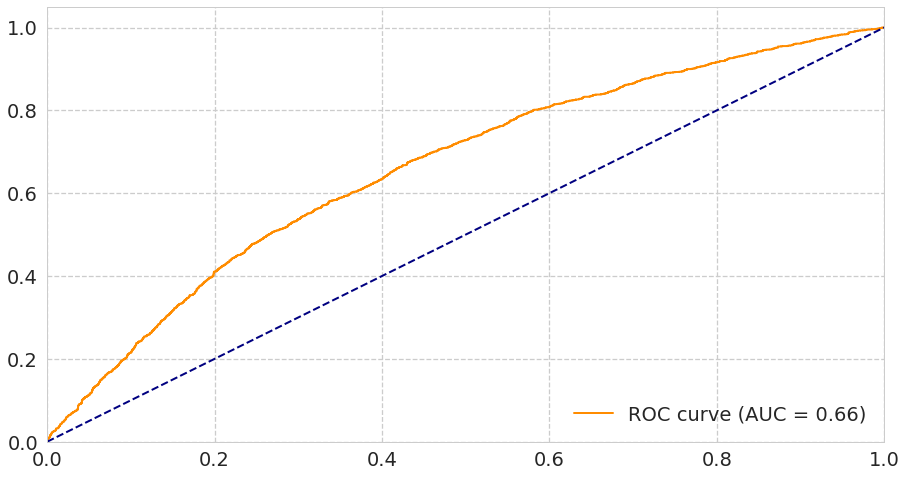

In [13]:
import warnings
warnings.filterwarnings('ignore')

# getting the accuracy measures
y_pred1 = pd.DataFrame(y_pred[:,0])
y_pred1['class'] = np.where((y_pred1[0] >= .75), 0, 1)
print(confusion_matrix(y_test,y_pred1['class']))
print(classification_report(y_test,y_pred1['class']))  
print(accuracy_score(y_test, y_pred1['class']))  

# checking accuracy at multiple threshold of probability output
threshold = [0.10,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
acc = []
for i in threshold:
    y_pred1 = pd.DataFrame(y_pred[:,0])
    y_pred1['class'] = np.where((y_pred1[0] >= i), 0, 1)
    acc.append(accuracy_score(y_test, y_pred1['class']))  

# getting the AUC curve
sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Ricty',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr, tpr)

lw = 2
plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

The above accuracy metric shows us that the prediction is far from perfect, but it is quite a bit better than randomly guessing (AUC = 0.5) if something will be viral or not.

## Future Directions

In order to improve this model, after it has been implemented, we can continue to tune it based on new incoming data. Since viral trends are often changing, it will be important for the model to be dynamic. 

Further, it will be useful to conduct LDA analysis ourselves in order to get a better sense of which LDA topics are strong predictors of virality. 